# Item analysis

Note: `npm run export-items` first.

In [2]:
import collections
import json
from pathlib import Path
from typing import Any, Iterable

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"figure.figsize": (5, 3), "axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

def load_items() -> list[dict[str, Any]]:
    return list(json.loads(Path("items.json").read_text()).values())

grid_size = (9, 9)
offer_count = 3

## Selection likelihood

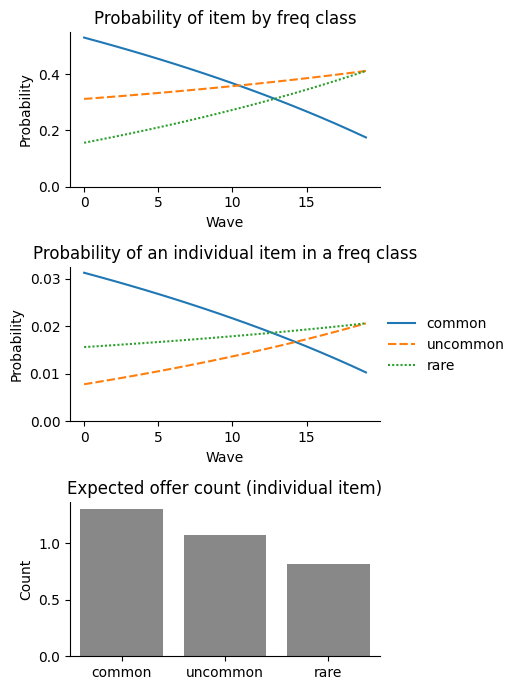

In [9]:
def linear_schedule(start: dict[str, float], end: dict[str, float], duration: int) -> list[dict[str, float]]:
    schedule = []
    for step in range(duration):
        t = step / (duration - 1)
        current = {key: start[key] + t * (end[key] - start[key]) for key in start}
        schedule.append(current)
    return schedule

def compute_selection_likelihoods(schedule: Iterable[dict[str, float]]) -> Iterable[dict[str, float]]:
    for chance in schedule:
        total_weight = sum(chance[freq] * items_by_freq[freq] for freq in chance)
        yield {freq: (chance[freq] * items_by_freq[freq]) / total_weight for freq in chance}

items = load_items()
items_by_freq = collections.Counter(item["freq"] for item in items)
schedule = linear_schedule(dict(common=4, uncommon=2, rare=1), dict(common=1, uncommon=2, rare=2), 20)

df = pd.DataFrame.from_dict(list(compute_selection_likelihoods(schedule)))

fig, axs = plt.subplots(3, 1, figsize=(4, 7))
sns.lineplot(data=df, ax=axs[0])
axs[0].set_title("Probability of item by freq class")
sns.lineplot(data=df / pd.Series(items_by_freq), ax=axs[1])
axs[1].set_title("Probability of an individual item in a freq class")
# sns.barplot(data=df / pd.Series(items_by_freq) * offer_count, ax=axs[2])
sns.barplot((df / pd.Series(items_by_freq) * offer_count).sum(), ax=axs[2], color="#888", order=["common", "uncommon", "rare"])
axs[2].set_title("Expected offer count (individual item)")
for ax in axs:
    ax.set_ylim(0, None)
    if ax.legend_:
        ax.legend_.remove()
axs[0].set_ylabel("Probability")
axs[1].set_ylabel("Probability")
axs[0].set_xlabel("Wave")
axs[1].set_xlabel("Wave")
axs[2].set_ylabel("Count")
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()

## Pattern likelihood

In [145]:
def pattern_expected_count(pattern_size: tuple[int, int]) -> float:
    chance = (1/2) ** (pattern_size[0] * pattern_size[1])
    placements = (grid_size[0] - pattern_size[0] + 1) * (grid_size[1] - pattern_size[1] + 1)
    return placements * chance

items = load_items()
pattern_shapes = {(x["grid"]["rows"], x["grid"]["cols"]) for x in items if x["kind"] == "pattern"}
df = pd.DataFrame.from_records([
    dict(shape=f"{w}x{h}", count=pattern_expected_count((w, h)))
    for w, h in pattern_shapes
])
df["fair_score"] = df["count"].max() / df["count"]
print("Score based on expected occurence count:")
display(df[["shape", "fair_score"]].sort_values("fair_score").reset_index(drop=True).style.format({"fair_score": "{:.1f}"}))

print("Expected score by pattern:")
display(pd.DataFrame.from_records([
    dict(
        name=item["name"],
        shape=f"{item['grid']['rows']}x{item['grid']['cols']}",
        expected_score=item["points"] * pattern_expected_count((item["grid"]["rows"], item["grid"]["cols"])),
        freq=item["freq"],
    )
    for item in items if item["kind"] == "pattern"
]).sort_values("expected_score", ascending=False).reset_index(drop=True).style.format({"expected_score": "{:.1f}"}))

Score based on expected occurence count:


,shape,fair_score
0,2x2,1.0
1,1x4,1.2
2,4x1,1.2
3,2x3,4.6
4,3x2,4.6
5,1x6,7.1
6,6x1,7.1
7,3x3,41.8
8,5x2,102.4
9,4x3,390.1


Expected score by pattern:


,name,shape,expected_score,freq
0,square_s,2x2,12.0,common
1,cleveland_z,2x3,10.5,common
2,rhode_island_z,2x3,10.5,common
3,l,3x2,10.5,common
4,c,3x2,10.5,uncommon
5,column,4x1,10.1,uncommon
6,line,1x4,10.1,uncommon
7,b2,3x3,7.2,rare
8,r_pentomino,3x3,7.2,rare
9,line_l,1x6,5.6,uncommon


## Coverage

In [11]:
df = pd.read_json(Path("items.json")).T
print("Total:", len(df))
print("Frequency:")
display(df.groupby("freq").size().to_frame("count").style.background_gradient("coolwarm"))
print("Kind:")
display(df.groupby("kind").size().to_frame("count").style.background_gradient("coolwarm"))
print("Kind & Frequency:")
display(
    df.groupby(["kind", "freq"]).size().to_frame("count").reset_index()
    .pivot(columns="freq", index="kind", values="count").fillna(0)
    .style.background_gradient("coolwarm"))

Total: 57
Frequency:


,count
freq,
common,17
rare,20
uncommon,20


Kind:


,count
kind,
action,5
bonus,25
pattern,27


Kind & Frequency:


freq,common,rare,uncommon
kind,,,
action,0.000000,3.000000,2.000000
bonus,9.000000,8.000000,8.000000
pattern,8.000000,9.000000,10.000000
